<a href="https://colab.research.google.com/github/Suhit97/Name-Entity-Recognition-/blob/master/NER_using_Keras_and_Lime.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Colab's file access feature
from google.colab import files

#retrieve uploaded file
uploaded = files.upload()

#print results
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 67 bytes


In [ ]:
!kaggle datasets download -d abhinavwalia95/entity-annotated-corpus -p /content

 34% 9.00M/26.4M [00:00<00:01, 13.1MB/s]
100% 26.4M/26.4M [00:00<00:00, 31.9MB/s]


In [ ]:
!unzip \entity-annotated-corpus.zip

Archive:  entity-annotated-corpus.zip
  inflating: ner.csv                 
  inflating: ner_dataset.csv         


In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm, trange

data = pd.read_csv("ner_dataset.csv",encoding="latin1").fillna(method="ffill")
data.tail(10)

,Sentence #,Word,POS,Tag
1048565,Sentence: 47958,impact,NN,O
1048566,Sentence: 47958,.,.,O
1048567,Sentence: 47959,Indian,JJ,B-gpe
1048568,Sentence: 47959,forces,NNS,O
1048569,Sentence: 47959,said,VBD,O
1048570,Sentence: 47959,they,PRP,O
1048571,Sentence: 47959,responded,VBD,O
1048572,Sentence: 47959,to,TO,O
1048573,Sentence: 47959,the,DT,O
1048574,Sentence: 47959,attack,NN,O


In [ ]:
words = list(set(data["Word"].values))
n_words = len(words);
n_words

35178

In [ ]:
tags = list(set(data["Tag"].values))
n_tags = len(tags);
n_tags

17

In [ ]:
class SentenceGetter(object):
    
    def __init__(self, data):
       self.n_sent = 1
       self.data = data
       self.empty = False
       agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
       self.grouped = self.data.groupby("Sentence #").apply(agg_func)
       self.sentences = [s for s in self.grouped]

    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None  

In [ ]:
getter = SentenceGetter(data)
sentences = getter.sentences

In [ ]:
sentences[0]

[('Thousands', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('demonstrators', 'NNS', 'O'),
 ('have', 'VBP', 'O'),
 ('marched', 'VBN', 'O'),
 ('through', 'IN', 'O'),
 ('London', 'NNP', 'B-geo'),
 ('to', 'TO', 'O'),
 ('protest', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('war', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('Iraq', 'NNP', 'B-geo'),
 ('and', 'CC', 'O'),
 ('demand', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('withdrawal', 'NN', 'O'),
 ('of', 'IN', 'O'),
 ('British', 'JJ', 'B-gpe'),
 ('troops', 'NNS', 'O'),
 ('from', 'IN', 'O'),
 ('that', 'DT', 'O'),
 ('country', 'NN', 'O'),
 ('.', '.', 'O')]

In [ ]:
labels = [[s[2] for s in sent] for sent in sentences]
sentences = [" ".join([s[0] for s in sent]) for sent in sentences]
sentences[0]


'Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country .'

In [ ]:
print(labels[0])

['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O']


## Preprocessing the data

### We first build a vocabulary of the most common 5000 words and map the rest to the “UNK” token.

In [ ]:
from collections import Counter
from tensorflow.keras.preprocessing.sequence import pad_sequences

word_cnt = Counter(data["Word"].values)
vocabulary = set(w[0] for w in word_cnt.most_common(5000))

### Now we create the word index and pad the sequence to a common length.

In [ ]:
max_len = 50
word2idx = {"PAD": 0, "UNK": 1}
word2idx.update({w: i for i,w in enumerate(words) if w in vocabulary})
tag2idx = {t: i for i, t in enumerate(tags)}

In [ ]:
X = [[word2idx.get(w, word2idx["UNK"]) for w in s.split()] for s in sentences]


In [ ]:
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=word2idx["PAD"])

In [ ]:
y = [[tag2idx[l_i] for l_i in l] for l in labels]


In [ ]:
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])

### we split the data in train and test set.

In [ ]:
from sklearn.model_selection import train_test_split

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.1, shuffle=False)

## Setup the NER model

We use the simple LSTM model. But the procedure shown here applies to all kinds of sequence models.


In [ ]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, SpatialDropout1D, Bidirectional


Using TensorFlow backend.


In [ ]:

word_input = Input(shape=(max_len,))
model = Embedding(input_dim=n_words, output_dim=50, input_length=max_len)(word_input)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(n_tags, activation="softmax"))(model)


In [ ]:
model = Model(word_input, out)
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 50)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 50, 50)            1758900   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 50, 50)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 50, 200)           120800    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 50, 17)            3417      
Total params: 1,883,117
Trainable params: 1,883,117
Non-trainable params: 0
_________________________________________________________________


In [ ]:

history = model.fit(X_tr, y_tr.reshape(*y_tr.shape, 1),
                    batch_size=32, epochs=5,
                    validation_split=0.1, verbose=1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 38846 samples, validate on 4317 samples
Epoch 1/5
38846/38846 [==============================] - 236s 6ms/step - loss: 0.1435 - accuracy: 0.9633 - val_loss: 0.0700 - val_accuracy: 0.9800
Epoch 2/5
38846/38846 [==============================] - 228s 6ms/step - loss: 0.0650 - accuracy: 0.9808 - val_loss: 0.0607 - val_accuracy: 0.9823
Epoch 3/5
38846/38846 [==============================] - 225s 6ms/step - loss: 0.0588 - accuracy: 0.9825 - val_loss: 0.0581 - val_accuracy: 0.9831
Epoch 4/5
38846/38846 [==============================] - 225s 6ms/step - loss: 0.0557 - accuracy: 0.9833 - val_loss: 0.0564 - val_accuracy: 0.9831
Epoch 5/5
38846/38846 [==============================] - 225s 6ms/step - loss: 0.0538 - accuracy: 0.9838 - val_loss: 0.0552 - val_accuracy: 0.9836


In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()


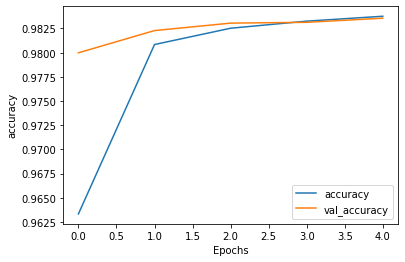

In [ ]:
plot_graphs(history, 'accuracy')


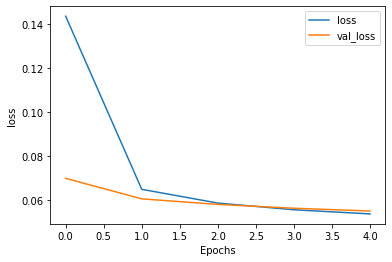

In [ ]:
plot_graphs(history, 'loss')

## Explain the predictions

To explain the predictions, we use the LIME algorithm implemented in the eli5 library. 

In [ ]:
#!pip install eli5

     |████████████████████████████████| 112kB 9.0MB/s 


In [ ]:
from eli5.lime import TextExplainer
from eli5.lime.samplers import MaskingTextSampler

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


Now we create a small python class, that holds our preprocessing and prediction of the model. To apply LIME we just need a function to make predictions on texts. We use the closure pattern in get_predict_function which returns a function that takes a list of texts, processes them and returns the predictions of our previously trained model.

## The trick

To make the LIME algorithm work for us, we need to rephrase our problem as a simple multiclass classification problem. We do this by selecting before-hand for which word we want to explain the prediction. This is done by passing the word_index to the get_predict_function method.

In [ ]:
class NERExplainerGenerator(object):
    
    def __init__(self, model, word2idx, tag2idx, max_len):
        self.model = model
        self.word2idx = word2idx
        self.tag2idx = tag2idx
        self.idx2tag = {v: k for k,v in tag2idx.items()}
        self.max_len = max_len
        
    def _preprocess(self, texts):
        X = [[self.word2idx.get(w, self.word2idx["UNK"]) for w in t.split()]
             for t in texts]
        X = pad_sequences(maxlen=self.max_len, sequences=X,
                          padding="post", value=self.word2idx["PAD"])
        return X
    
    def get_predict_function(self, word_index):
        def predict_func(texts):
            X = self._preprocess(texts)
            p = self.model.predict(X)
            return p[:,word_index,:]
        return predict_func

Let’s have a look at some interesting samples. For example the 46781th text in our data set.

In [ ]:
index = 46781
label = labels[index]
text = sentences[index]
print(text)
print()
print(" ".join([f"{t} ({l})" for t, l in zip(text.split(), label)]))

Nigeria 's President Olusegun Obasanjo expressed his condolences , noting the late pontiff promoted religious tolerance and democracy in the West African nation .

Nigeria (B-geo) 's (O) President (B-per) Olusegun (I-per) Obasanjo (I-per) expressed (O) his (O) condolences (O) , (O) noting (O) the (O) late (O) pontiff (O) promoted (O) religious (O) tolerance (O) and (O) democracy (O) in (O) the (O) West (O) African (B-gpe) nation (O) . (O)


In [ ]:
for i, w in enumerate(text.split()):
    print(f"{i}: {w}")
    

0: Nigeria
1: 's
2: President
3: Olusegun
4: Obasanjo
5: expressed
6: his
7: condolences
8: ,
9: noting
10: the
11: late
12: pontiff
13: promoted
14: religious
15: tolerance
16: and
17: democracy
18: in
19: the
20: West
21: African
22: nation
23: .


Now start to explain the prediction. We first initialize our generator object.

In [ ]:
explainer_generator = NERExplainerGenerator(model, word2idx, tag2idx, max_len)

We want to explain the NER prediction for the word “Obasanjo”, so we pick word_index=4 and generate the respective prediction function.

In [ ]:
word_index = 4
predict_func = explainer_generator.get_predict_function(word_index=word_index)

Here we have to specify a sampler for the LIME algorithm. This controls how the algorithm samples perturbed samples from the text we want to explain. Read more about this in the eli5 documentation.

In [ ]:
sampler = MaskingTextSampler(
    replacement="UNK",
    max_replace=0.7,
    token_pattern=None,
    bow=False)

In [ ]:
samples, similarity = sampler.sample_near(text, n_samples=4)
print(samples)

("Nigeria 'UNK President Olusegun Obasanjo expressed his condolences , noting the late pontiff promoted religious tolerance and democracy in the West African nation .", "UNK 's UNK UNK UNK UNK his condolences , noting UNK UNK pontiff promoted religious tolerance and UNK in UNK UNK UNK UNK .", "UNK 's UNK UNK Obasanjo UNK UNK UNK , noting UNK UNK UNK UNK UNK tolerance UNK UNK UNK the UNK African UNK .", "Nigeria 'UNK UNK Olusegun Obasanjo expressed his condolences , UNK the late pontiff promoted religious tolerance UNK UNK in UNK UNK UNK nation .")


Finally, we set up the TextExplainer and explain the prediction.

In [ ]:
te = TextExplainer(
    sampler=sampler,
    position_dependent=True,
    random_state=42
)

te.fit(text, predict_func)

te.explain_prediction(
    target_names=list(explainer_generator.idx2tag.values()),
    top_targets=3
)

Explanation(estimator="SGDClassifier(alpha=0.001, average=False, class_weight=None,\n              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,\n              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,\n              n_iter_no_change=5, n_jobs=None, penalty='elasticnet',\n              power_t=0.5, random_state=RandomState(MT19937) at 0x7FB06FD47DB0,\n              shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,\n              warm_start=False)", description=None, error=None, method='linear model', is_regression=False, targets=[TargetExplanation(target='I-per', feature_weights=FeatureWeights(pos=[FeatureWeight(feature='[2] President', weight=2.2251412091069915, std=None, value=1.0), FeatureWeight(feature='[4] Obasanjo', weight=1.5929926347338808, std=None, value=1.0), FeatureWeight(feature='[5] expressed', weight=0.8815893340083445, std=None, value=1.0), FeatureWeight(feature='[6] his', weight=0.23381493645072746, std=None, value=1.0), FeatureWeight(feature='[3] Olusegun', weight=0.05684393067718702, std=None, value=1.0), FeatureWeight(feature='[12] promoted', weight=0.05181759364692056, std=None, value=1.0), FeatureWeight(feature='[17] in', weight=0.040469497902675566, std=None, value=1.0), FeatureWeight(feature='[8] noting', weight=0.036356555215401265, std=None, value=1.0), FeatureWeight(feature='[13] religious', weight=0.033422094493483316, std=None, value=1.0), FeatureWeight(feature='[18] the', weight=0.0035533309517943616, std=None, value=1.0)], neg=[FeatureWeight(feature='[1] s', weight=-1.1311691756369515, std=None, value=1.0), FeatureWeight(feature='<BIAS>', weight=-0.2570193977661488, std=None, value=1.0), FeatureWeight(feature='[10] late', weight=-0.05756737567365844, std=None, value=1.0), FeatureWeight(feature='[7] condolences', weight=-0.05355073498437412, std=None, value=1.0), FeatureWeight(feature='[0] Nigeria', weight=-0.04998547959304318, std=None, value=1.0), FeatureWeight(feature='[19] West', weight=-0.03527442683030908, std=None, value=1.0), FeatureWeight(feature='[9] the', weight=-0.013337694967911866, std=None, value=1.0)], pos_remaining=0, neg_remaining=0), proba=0.9531966049048288, score=3.558096831735009, weighted_spans=WeightedSpans(docs_weighted_spans=[DocWeightedSpans(document="Nigeria 's President Olusegun Obasanjo expressed his condolences , noting the late pontiff promoted religious tolerance and democracy in the West African nation .", spans=[('Nigeria', [(0, 7)], -0.04998547959304318), ('s', [(9, 10)], -1.1311691756369515), ('President', [(11, 20)], 2.2251412091069915), ('Olusegun', [(21, 29)], 0.05684393067718702), ('Obasanjo', [(30, 38)], 1.5929926347338808), ('expressed', [(39, 48)], 0.8815893340083445), ('his', [(49, 52)], 0.23381493645072746), ('condolences', [(53, 64)], -0.05355073498437412), ('noting', [(67, 73)], 0.036356555215401265), ('the', [(74, 77)], -0.013337694967911866), ('late', [(78, 82)], -0.05756737567365844), ('promoted', [(91, 99)], 0.05181759364692056), ('religious', [(100, 109)], 0.033422094493483316), ('in', [(134, 136)], 0.040469497902675566), ('the', [(137, 140)], 0.0035533309517943616), ('West', [(141, 145)], -0.03527442683030908)], preserve_density=False, vec_name=None)], other=FeatureWeights(pos=[FeatureWeight(feature=<FormattedFeatureName 'Highlighted in text (sum)'>, weight=3.815116229501158, std=None, value=None)], neg=[FeatureWeight(feature='<BIAS>', weight=-0.2570193977661488, std=None, value=1.0)], pos_remaining=0, neg_remaining=0)), heatmap=None), TargetExplanation(target='I-geo', feature_weights=FeatureWeights(pos=[FeatureWeight(feature='[1] s', weight=0.8526545907026647, std=None, value=1.0), FeatureWeight(feature='[0] Nigeria', weight=0.6262882292115681, std=None, value=1.0), FeatureWeight(feature='[5] expressed', weight=0.33653041784477217, std=None, value=1.0), FeatureWeight(feature='[10] late', weight=0.14752503971241576, std=None, value=1.0), FeatureWeight(feature='[19] West', weight=0.076192744